For imagej lookup:
https://py.imagej.net/en/latest/notebooks.html
https://py.imagej.net/en/latest/06-Working-with-Images.html
https://py.imagej.net/en/latest/10-Using-ImageJ-Ops.html#using-imagej-ops

In [1]:
import imagej
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Note to self: mode=interaction to run ij.ui.show
# Refer to 6.3:
# https://py.imagej.net/en/latest/06-Working-with-Images.html
ij = imagej.init('sc.fiji:fiji',mode='interactive')  # Interactive mode
image = ij.io().open('balls1-2048x2048.tif')
image_f32 = ij.op().run("convert.float32", image)


# https://py.imagej.net/en/latest/06-Working-with-Images.html
# ij.py.show(image, cmap='gray')  # Display the image in grayscale
ij.ui().show(image)  # Display the image in grayscale
# ij.py.show(image,cmap='hvs')  # Display the image in grayscale


[INFO] Found 10 JHotDraw adapters.


In [3]:
def plane(image, pos):
    """
    Slices an image plane at the given position.
    :param image: the image to slice
    :param pos: a dictionary from dimensional axis label to element index for that dimension
    """
    # Convert pos dictionary to position indices in dimension order.
    # See https://stackoverflow.com/q/39474396/1207769.
    p = tuple(pos[image.dims[d]] if image.dims[d] in pos else slice(None) for d in range(image.ndim))
    return image[p]

In [15]:
print(image.dims)

('X', 'Y')


In [11]:
import ipywidgets


def _axis_index(image, *options):
    axes = tuple(d for d in range(image.ndim) if image.dims[d].lower() in options)
    if len(axes) == 0:
        raise ValueError(f"Image has no {options[0]} axis!")
    return axes[0]

def ndshow(image, cmap=None, x_axis=None, y_axis=None, immediate=False):
    if not hasattr(image, 'dims'):
        # We need dimensional axis labels!
        raise TypeError("Metadata-rich image required")

    # Infer X and/or Y axes as needed.
    if x_axis is None:
        x_axis = _axis_index(image, "x", "col")
    if y_axis is None:
        y_axis = _axis_index(image, "y", "row")

    # Build ipywidgets sliders, one per non-planar dimension.
    widgets = {}
    for d in range(image.ndim):
        if d == x_axis or d == y_axis:
            continue
        label = image.dims[d]
        widgets[label] = ipywidgets.IntSlider(description=label, max=image.shape[d]-1, continuous_update=immediate)

    # Create image plot with interactive sliders.
    def recalc(**kwargs):
        print("displaying")
        ij.py.show(plane(image, kwargs), cmap=cmap)
    ipywidgets.interact(recalc, **widgets)


In [13]:
ndshow(image)

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [16]:
def dump_info(image):
    """A handy function to print details of an image object."""
    name = image.name if hasattr(image, 'name') else None # xarray
    if name is None and hasattr(image, 'getName'): name = image.getName() # Dataset
    if name is None and hasattr(image, 'getTitle'): name = image.getTitle() # ImagePlus
    print(f" name: {name or 'N/A'}")
    print(f" type: {type(image)}")
    print(f"dtype: {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
    print(f"shape: {image.shape}")
    print(f" dims: {image.dims if hasattr(image, 'dims') else 'N/A'}")

dump_info(image)

 name: balls1-2048x2048.tif
 type: <java class 'net.imagej.DefaultDataset'>
dtype: <java class 'net.imglib2.type.numeric.integer.UnsignedByteType'>
shape: (2048, 2048)
 dims: ('X', 'Y')


In [46]:
# xarr = ij.py.from_java(image)
# fft_image_xarr = np.fft.fft2(xarr)
# fft_magnitude = np.abs(fft_image_xarr)
# fft_normalized = 255 * (fft_magnitude - fft_magnitude.min()) / (fft_magnitude.max() - fft_magnitude.min())
# fft_image = ij.py.to_java(fft_normalized)
# ij.py.show(fft_image)

fft_result = ij.op().run("filter.fft", image)
ij.py.show(fft_result)

Exception: 
java.lang.ClassCastException
Error: Unsupported type cast via net.imglib2.util.Images.copy
    Source type: net.imglib2.type.numeric.complex.ComplexFloatType
    Target type: net.imglib2.type.numeric.real.AbstractRealType
Error: Unsupported type cast via net.imagej.ops.copy.CopyNamespace.rai
    Source type: net.imglib2.type.numeric.complex.ComplexFloatType
    Target type: net.imglib2.type.numeric.real.AbstractRealType

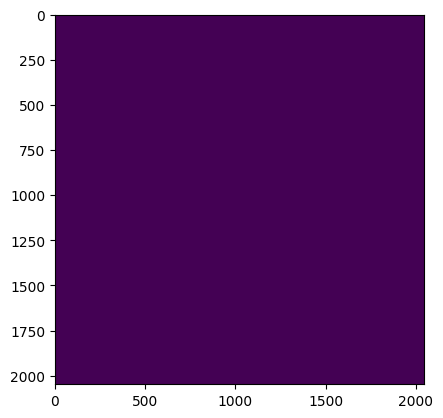

In [ ]:
image = ij.io().open('balls1-2048x2048.tif')

# fft_image_xarr = np.fft.fft(xarr)
# fft_magnitude = np.abs(fft_image_xarr)
fft_image = ij.py.to_java(fft_magnitude)
ij.py.show(fft_image)

In [51]:
# Not Important
# Convert image to numpy array for visualization
image = ij.io().open('balls1-2048x2048.tif')
image_np = ij.py.from_java(image)
fft_result = ij.op().run("filter.fft", image)
# display with grayscale
ij.py.show(fft_result)



Exception: 
java.lang.ClassCastException
Error: Unsupported type cast via net.imglib2.util.Images.copy
    Source type: net.imglib2.type.numeric.complex.ComplexFloatType
    Target type: net.imglib2.type.numeric.real.AbstractRealType
Error: Unsupported type cast via net.imagej.ops.copy.CopyNamespace.rai
    Source type: net.imglib2.type.numeric.complex.ComplexFloatType
    Target type: net.imglib2.type.numeric.real.AbstractRealType

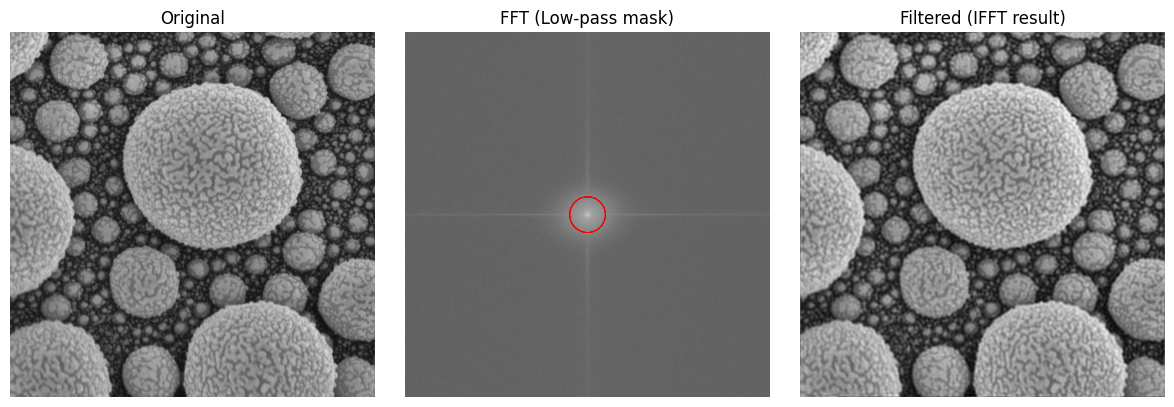

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

# Step 1: Load image using ImageJ and convert to NumPy
image = ij.io().open('balls1-2048x2048.tif')
image_np = ij.py.from_java(image).astype(np.float32)

# Step 2: Forward FFT
fft = np.fft.fft2(image_np)
fft_shifted = np.fft.fftshift(fft)

# Step 3: Create Low-Pass Filter Mask
rows, cols = image_np.shape
crow, ccol = rows // 2, cols // 2
radius = 100  # radius of low-pass filter

mask = np.zeros_like(image_np)
y, x = np.ogrid[:rows, :cols]
mask_area = (x - ccol)**2 + (y - crow)**2 <= radius**2
mask[mask_area] = 1

# Step 4: Apply Filter in Frequency Domain
fft_filtered = fft_shifted * mask

# Step 5: Inverse FFT
ifft_shifted = np.fft.ifftshift(fft_filtered)
image_filtered = np.fft.ifft2(ifft_shifted)
image_filtered_real = np.abs(image_filtered)

# Step 6: Display
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("FFT (Low-pass mask)")
plt.imshow(np.log1p(np.abs(fft_shifted)), cmap='gray')
plt.contour(mask, colors='r', linewidths=0.5)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Filtered (IFFT result)")
plt.imshow(image_filtered_real, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


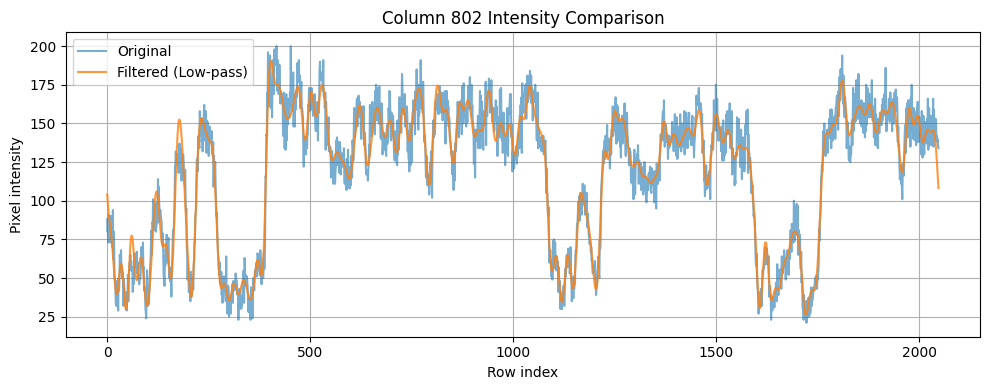

In [53]:
# Pick a random or fixed column index
col_idx = np.random.randint(0, image_np.shape[1])  # or col_idx = 1024

# Extract column pixel intensities
original_col = image_np[:, col_idx]
filtered_col = image_filtered_real[:, col_idx]

# Plot the column comparison
plt.figure(figsize=(10, 4))
plt.plot(original_col, label='Original', alpha=0.6)
plt.plot(filtered_col, label='Filtered (Low-pass)', alpha=0.8)
plt.title(f"Column {col_idx} Intensity Comparison")
plt.xlabel("Row index")
plt.ylabel("Pixel intensity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
original = image_np
filtered = image_filtered_real
noise = original - filtered

noise_std = np.std(noise)
print(f"Noise standard deviation: {noise_std:.4f}")

signal_power = np.mean(original**2)
noise_power = np.mean((original - filtered)**2)
snr = 10 * np.log10(signal_power / noise_power)
print(f"SNR: {snr:.2f} dB")

peak = np.max(original)
mse = np.mean((original - filtered) ** 2)
psnr = 10 * np.log10((peak ** 2) / mse)
print(f"PSNR: {psnr:.2f} dB")

# FFT energy before and after
energy_original = np.sum(np.abs(fft_shifted)**2)
energy_filtered = np.sum(np.abs(fft_filtered)**2)
energy_removed = energy_original - energy_filtered
energy_pct = (energy_removed / energy_original) * 100

print(f"High-frequency energy removed: {energy_pct:.2f}%")




Noise standard deviation: 10.1941
SNR: 21.74 dB
PSNR: 27.96 dB
High-frequency energy removed: 0.67%


In [ ]:
ij.op().help("filter.fft")

In [ ]:
# ij = imagej.init()
print(f"ImageJ2 version: {ij.getVersion()}")